# Calculo de la entropía de entrelazamiento de un sistema sometido a un baño.

#### Carmen Martín Turrero

El objetivo de esta simulación es estudiar un universo formado por un sistema cuya base es $\rvert\uparrow\rangle$, $\rvert\downarrow\rangle$, sometido a un baño en equilibrio a temperatura constante de dimensión _d = N_ con base $\begin{pmatrix} 1 \\ 0 \\ 0 \\ \vdots \\ 0\end{pmatrix}$, $\begin{pmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0\end{pmatrix}$, $\ldots$, $\begin{pmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1\end{pmatrix}$; cuyo Hamiltoniano es del tipo:

$$\mathcal{H} = \sigma_z + H_R + \sigma_x R$$

In [1]:
#Importamos los paquetes necesarios.
from numpy import array, dot, transpose, identity, linspace, zeros, sqrt, linalg, exp, kron, trace, log, append, arange, size
import numpy as np
from tenpy.linalg import random_matrix
from matplotlib.pyplot import show, plot, xlabel, ylabel, figure, legend,title, savefig, xlim, ylim

In [2]:
#Pedimos la dimensión del baño y su temperatura:
N = int(input("Introduzca la dimensión del baño: N = "))
T = float(input("Defina la temperatura del baño: T = "))

Introduzca la dimensión del baño: N = 250
Defina la temperatura del baño: T = 0.5


In [3]:
#Creamos dos matrices formadas por los elementos de las dos bases, para poder usar el código:
Sys = identity(2)
B = identity(N)

#Escribimos las matrices de Pauli:

sigmax = array([[0,1],
                [1,0]])
sigmaz = array([[1,0],
                [0,-1]])

In [4]:
#Damos valores al Hamiltoniano del baño H_r:
Hr = zeros((N,N))
diag = linspace(-0.5, 0.5, N)

for i in range(N):
    Hr[i,i] = diag[i]

Partimos de un estado inicial en el que no hay correlación entre el sistema y el baño, para ver como la evolución del Hamiltoniano produce dicha correlación.

$$\rvert\Psi(0)\rangle = \rvert\chi(0)\rangle \otimes \rvert\psi(0)\rangle$$

* Estado inicial del sistema, $\rvert\chi(0)\rangle$
* Estado inicial del baño, $\rvert\psi(0)\rangle$ : construímos un estado que simule cierta temperatura.

In [5]:
#Calculamos el estado inicial del Universo:
#Estado inicial del sistema
chi0 = Sys[:,0]

#Estado inicial del baño
beta = 1/T   #Tomamos k_B = 1

Z = 0
psi0 = zeros(N)

for i in range(N):
    #Sumatorio para hallar la función de partición
    Z = Z + exp(-beta*Hr[i,i])
    #Aprovechamos el bucle para crear el vector psi(0)
    psi0[i] = exp(-beta*Hr[i,i]/2)

psi0 = psi0/sqrt(Z)
#En este estado el baño está en equilibrio termodinámico a temperatura 1/beta.

#Estado inicial del Universo
Psi0 = kron(chi0,psi0)

Si calculamos este estado inicial en la base de autoestados del hamiltoniano, $\rvert\Psi(0)\rangle = \underset{n}{\sum}\langle\Psi_{0}\rvert E_{n}\rangle\rvert E_{n}\rangle\equiv\alpha_n\rvert E_{n}\rangle$, la evolución temporal en dicha base es:

$$\rvert\Psi(t)\rangle = \underset{n}{\sum}\alpha_n e^{-iE_{n}t/\hbar}\rvert E_{n}\rangle $$

In [6]:
#Definimos la función de la evolución temporal del estado, que vamos a necesitar:
def ev_temp(t):
    hbarra = 1
    Psit = 0
    for i in range(2*N):
        Psit += alpha[i]*exp(-1j*D[i,i]*t/hbarra)*Eigvect[:,i]
    return Psit

A continuación, modificamos el código para calcular la entropía de entrelazamiento y ver como varía en función de la aleatoriedad de la matriz R, introduciendo un bucle que abarque todos los resultados que se ven afectados por dicha matriz.

In [7]:
T = arange(0,100,0.1)   #Rango de tiempos para el que calculamos la entropía
num_ej = 6   #Número de hamiltonianos de interacción que queremos comparar
S_var = zeros((size(T),num_ej))

#Abrimos un bucle para ver como afecta la aleatoriedad de la matriz R a la entropía.

for ejecuciones in range(num_ej):
    #Damos valores a R:
    X = random_matrix.GOE((N,N))
    R = X/sqrt(8*N)
    
    #Construimos el hamiltoniano como una matriz 2Nx2N: H_nm = <n|H|m>

    H = zeros((2*N,2*N))
    p = 0

    for i in range(N):
        a = array(B[:,i])
        for m in range(2):
            b = array(Sys[:,m])
            q = 0
            for k in range(N):
                c = array(B[:,k])
                for l in range(2):
                    d = array(Sys[:,l])
                    H[p,q]= dot(b,dot(sigmaz,d))*dot(a,c) + dot(b,d)*dot(a,dot(Hr,c)) + dot(b,dot(sigmax,d))*dot(a,dot(R,c))
                    q = q+1
            p = p+1
    
    #Diagonalizamos el hamiltoniano
    Eigvals, Eigvect = np.linalg.eig(H)

    D = zeros((2*N,2*N))
    for i in range(2*N):
        D[i,i] = Eigvals[i]
    #Las columnas de la matriz Eigvect se corresponden con los autovalores de la misma posición en la matriz diagonal.
    #Es decir, el autovector de autovalor D(i,i) es Eigvect[:,i].
    
    #Calculamos el estado inicial en la base de autovectores del hamiltoniano (psi0 = alpha(i)*Eigvect(:,i))
    alpha = zeros(2*N)
    for i in range(2*N):
        alpha[i] = dot(Psi0,Eigvect[:,i])
        
    #Calculamos la entropía de entrelazamiento para distintos tiempos dados por 'T'
    for t in range(size(T)):
        Psit = ev_temp(T[t])
        #Realizamos el cambio de base:
        C = zeros((N,2), dtype = 'complex_')       #Vector de coeficientes para el estado en función del tiempo en la base original.
        for i in range(N):
            for k in range(2):
                C[i,k] = dot(Psit.conjugate(),kron(Sys[:,k],B[:,i]))
        #Calculamos la matriz densidad reducida del sistema:
        rho_s = zeros((2,2))
        for i in range(2):
            for n in range(2):
                A = 0
                for k in range(N):
                    A += C[k,i].conjugate()*C[k,n]
                rho_s[i,n] = A
        #Calculamos la entropía de entrelazamiento:
        lambd = np.linalg.eigvals(rho_s)
        S = 0
        for i in range(2):
            S += lambd[i]*log(lambd[i])
        S_var[t,ejecuciones] = -S

<ipython-input-7-98cfdf9d5f95>:59: ComplexWarning: Casting complex values to real discards the imaginary part
  rho_s[i,n] = A


Analizamos los resultados, representándolos.

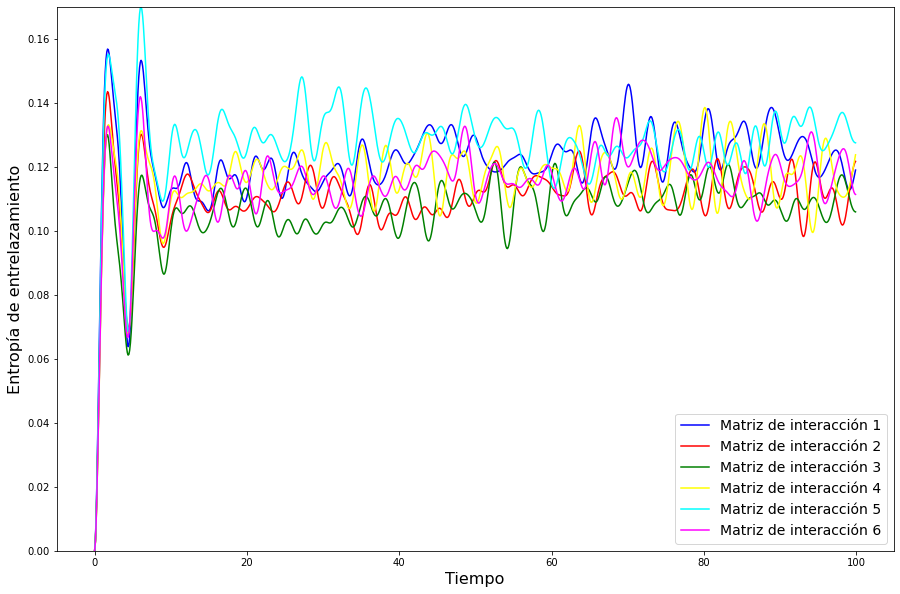

In [8]:
#Pintamos los resultados:
figure(figsize=(15, 10))

plot(T,S_var[:,0],"b", label = 'Matriz de interacción 1')
plot(T,S_var[:,1],"r", label = 'Matriz de interacción 2')
plot(T,S_var[:,2],"g", label = 'Matriz de interacción 3')
plot(T,S_var[:,3],"yellow", label = 'Matriz de interacción 4')
plot(T,S_var[:,4],"cyan", label = 'Matriz de interacción 5')
plot(T,S_var[:,5],"fuchsia", label = 'Matriz de interacción 6')

xlabel( "Tiempo", fontsize = 16, color="black")
ylabel("Entropía de entrelazamiento" , fontsize = 16, color="black")
ylim(0,0.17)
legend(fontsize=14)

show()

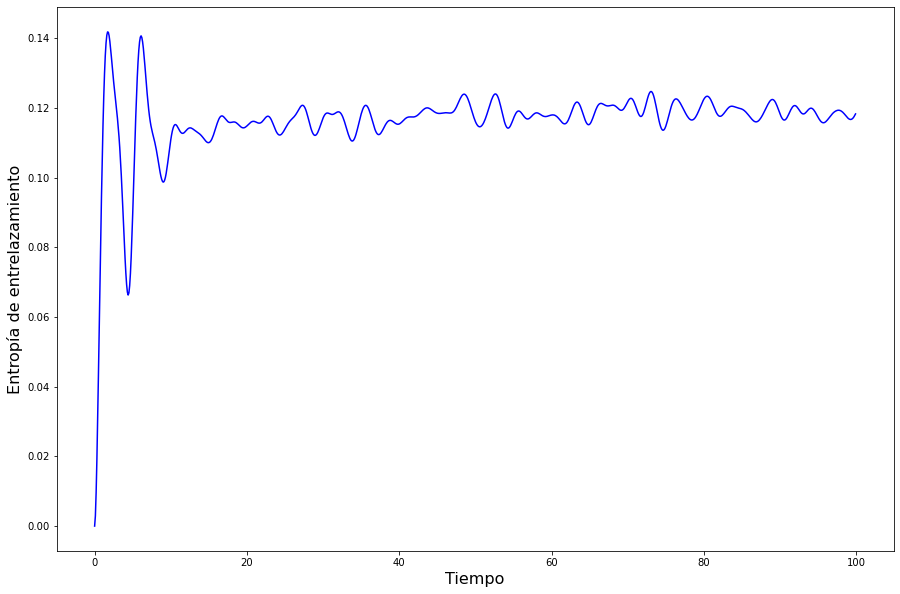

In [9]:
#Calculamos el promedio de las distintas entropías:
S_promedio = zeros(size(T))
for k in range(len(T)):
    S_promedio[k]= sum(S_var[k,:])/num_ej

figure(figsize=(15, 10))
plot(T,S_promedio,"b")

xlabel( "Tiempo", fontsize = 16, color="black")
ylabel("Entropía de entrelazamiento" , fontsize = 16, color="black")

show()